<a href="https://colab.research.google.com/github/litongzheng/APS360Project/blob/master/best%20model%2050%20epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [0]:
torch.__version__

'1.0.1.post2'

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
from google.colab import files
uploaded = files.upload()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
sp_text = ""

chars = []
i = 0
for char in open('/content/drive/My Drive/Colab Notebooks/character.txt'):
    chars.append(char.strip() + ":\t")
    if i>=4000:
        break
    i = i+1
lines = [] 

i = 0
for line in open('/content/drive/My Drive/Colab Notebooks/Line.txt', encoding='ISO-8859-1' ):
        lines.append(line)
        if i>=4000:
            break
        i = i+1
        
for i in range(len(lines)):
    total = chars[i] + lines[i]
    sp_text += total
    
vocab = list(set(sp_text))
vocab_stoi = {s: i for i, s in enumerate(vocab)}
vocab_itos = {i: s for i, s in enumerate(vocab)}
print(len(sp_text))
print(vocab_stoi)

292275
{'k': 0, 'D': 1, '8': 2, 'S': 3, 'F': 4, ':': 5, 'X': 6, 'Y': 7, ')': 8, '©': 9, '&': 10, 'h': 11, '?': 12, ',': 13, '%': 14, 'e': 15, '$': 16, '"': 17, 'c': 18, 'd': 19, 'P': 20, ';': 21, 'w': 22, '6': 23, 'Ì': 24, 'B': 25, '1': 26, '9': 27, '¬': 28, 'Á': 29, '4': 30, 'W': 31, 'À': 32, 'n': 33, 'K': 34, '2': 35, '#': 36, 'r': 37, 'å': 38, '+': 39, 't': 40, 'I': 41, 'o': 42, 'l': 43, 's': 44, 'x': 45, 'u': 46, '0': 47, 'z': 48, 'R': 49, ' ': 50, 'm': 51, '(': 52, 'U': 53, 'q': 54, 'a': 55, '-': 56, '/': 57, '±': 58, 'f': 59, 'b': 60, 'H': 61, 'i': 62, '3': 63, 'C': 64, '\ufeff': 65, '\t': 66, 'y': 67, 'v': 68, 'J': 69, 'G': 70, 'A': 71, "'": 72, 'p': 73, 'N': 74, 'M': 75, 'V': 76, 'T': 77, 'L': 78, 'Q': 79, '.': 80, '5': 81, 'Z': 82, 'g': 83, '7': 84, '!': 85, 'j': 86, 'E': 87, '\n': 88, 'O': 89}


In [0]:
import random
random.seed(10)

sp_len = len(sp_text) #get the length of the south park text 

def random_chunk(chunk_len=1000):
    """Return a random subsequence from `spam_text`"""
    start_index = random.randint(0, sp_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return sp_text[start_index:end_index] #gets a random chunk of size chunk len

def text_to_numpy(text, vocab=vocab):  #
    """Return a tensor containing the indices of characters in `text`."""
    indices = [vocab_stoi[ch] for ch in text]
    return np.asarray(indices)

  
example = text_to_numpy(random_chunk())
# print(example)


In [5]:
## based on ideas from https://github.com/thomasxmeng/Project-tv-script-generation-RNN/blob/master/dlnd_tv_script_generation_7.ipynb

def make_data_loader(sp_txt_np, inp_len, batch_size): 
    #create input target sequence pairs 
    length = len(sp_txt_np) #figure out how long the sp_text_np array is
    
    inp_list = []
    target_list = []
    start_ind = 0
    end_ind = inp_len
    tar_ind = inp_len
    
    #we want to return inputs and targets, where inputs are a vector array of sequence length 
    while (length-start_ind)> inp_len: #while we can still create a batch target pair 
      inp_list.append(sp_txt_np[start_ind:end_ind])
      target_list.append(sp_txt_np[tar_ind])
      
      #shift everything by 1
      start_ind +=1
      end_ind +=1
      tar_ind +=1
      
    #convert the inputs and targets into np arrays in order to convert them to torch tensors
    inputs = np.asarray(inp_list)
    targets = np.asarray(target_list)
      
    #create a data loader 
    data = TensorDataset(torch.from_numpy(inputs), torch.from_numpy(targets))
    data_loader = torch.utils.data.DataLoader(data, shuffle=True, batch_size=batch_size) #shuffle and add batch size
   
  # return a dataloader
    return data_loader
  
  
loader = make_data_loader(text_to_numpy(sp_text),30,1)
print(text_to_numpy(sp_text)[:4])
for i,j in loader:
    print(i.type())
    print(i.shape,len(j))
    break

[65  3 40 55]
torch.LongTensor
torch.Size([1, 30]) 1


In [0]:
class Cartmanboi(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1,dropout=0.2):
        super(Cartmanboi, self).__init__()
        # RNN attributes
        self.name = "c1"
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        # identity matrix for generating one-hot vectors on the chars 
        self.ident = torch.eye(vocab_size)
        # recurrent neural network
        self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True,dropout=dropout)
        # a fully-connect layer that decodes the RNN output to
        # a distribution over the vocabulary
        self.decoder = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inp, hidden):
        batch_size = inp.size(0) #figure out what the size of the input is 
        # generate one-hot vectors from token indices
        inp = self.ident[inp].cuda()
        # obtain the next output and hidden state
        #print(inp.shape)
        output, hidden = self.rnn(inp, hidden)
        output = self.decoder(output.squeeze(0))
        output = output.view(batch_size, -1, self.vocab_size)

        output = output[:,-1] #take the last output 
        return output, hidden

    def init_hidden(self,batch_size): #this returns a hidden size the same size as the batch size 
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).cuda()

In [0]:
def get_model_name(name, batch_size, learning_rate, epoch,hidden_size, layers,sq):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    model_name = 'model_{0}_bs{1}_lr{2}_epoch{3}_h{4}_l{5}_sq{6}'.format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch,
                                                   hidden_size, layers,sq)
    path = F"/content/drive/My Drive/Colab Notebooks/{model_name}"
    return path

In [0]:
device = torch.device('cuda:0')

## **Training**

In [0]:
def evaluate(model, prime_str='Kyle:', sq_length=30, predict_len=500, temperature=0.8):
    hidden = model.init_hidden(1) #create a hidden layer the size of our prime string 
    prime_input = text_to_numpy(prime_str) #convert out prime string to a np array vector 
    
    
    #create a matrix the same size as our input batches 
    current_seq = np.full((1, sq_length), vocab_stoi[" "]) #create a vector to hold the predicted characters 
    
    current_seq[-1][len(current_seq)-len(prime_input)-1:] = prime_input
    predicted = prime_str #predicted holds the predicted sequence 
    current_seq = torch.from_numpy(current_seq)
#     model.cuda()
    for p in range(predict_len):  #for however many characters we want to predict 
        current_seq = torch.LongTensor(current_seq).cuda() #turn our current sequence into a long tensor 
        output, hidden = model(current_seq, hidden)
#         print(hidden.shape)
#         print(current_seq.shape)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted character to string and use as next input
        predicted_char = vocab_itos[top_i] #figure out what the predicted character is
        predicted += predicted_char
        
#         print(current_seq)
        current_seq = np.roll(current_seq.cpu(), -1, 1)
#         print(current_seq)
        current_seq[-1][-1] = top_i
#         print(current_seq)

    return predicted

def train(model, num_epochs=50, batch_size = 128, lr=0.001,sq=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    #convert the text into a vector aray, how many previous chars to use for prediction, the size of the batch
    train_loader =  make_data_loader(text_to_numpy(sp_text),sq ,batch_size) 
    model.cuda()
    
    losses = []
    epochs = []

    for epoch in range(num_epochs):
        hidden = model.init_hidden(batch_size)
        for inp,tar in train_loader: #note that we don't have a validation loader 
            if len(tar) == batch_size:
#                 hidden =hidden.type(torch.cuda.LongTensor)
#                 print(hidden.type())
                inp, tar = inp.cuda(), tar.cuda()
#                 print(inp.type())
                optimizer.zero_grad()
                output,_ = model(inp,hidden)
                loss = criterion(output, tar)
                loss.backward()
                optimizer.step() 
        losses.append(float(loss))
        epochs.append(epoch)

        print("[Epoch %d] Loss %f" % (epoch+1, float(loss)))
        model_path = get_model_name(model.name, batch_size, lr, epoch,model.hidden_size,model.n_layers,sq)
        torch.save(model, model_path)
        print(evaluate(model,prime_str="Kyle:"))
        
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()



### **Tuning**

In [0]:
model = Cartmanboi(len(vocab),256,2)
train(model,num_epochs=20,batch_size=64, lr=2e-4)

In [0]:
model_1 = Cartmanboi(len(vocab),256,2)
train(model_1,num_epochs=20,batch_size=128, lr=2e-4)

In [0]:
model_2 = Cartmanboi(len(vocab),512,2,dropout=0.5)
train(model_2,num_epochs=20,batch_size=128, lr=0.001,sq=50)

In [0]:
model4 = Cartmanboi(len(vocab),128,3,dropout=0.3)
train(model4,num_epochs=20,batch_size=64, lr=0.001,sq=50)

In [0]:
model_3 = Cartmanboi(len(vocab),128,dropout=0)
train(model_3,num_epochs=2,batch_size=64, lr=2e-4)

In [0]:
model = Cartmanboi(len(vocab),256,2)
train(model,num_epochs=20,batch_size=64, lr=3e-4,sq=50)

[Epoch 1] Loss 1.612069


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Cartmanboi. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Kyle:	I've now lest the foinglee to you're guys! 
Jealis:	Not like to Ked an the espoon like you gonnathen like way of the hampers. 
Stan:	Ak. I don't your be a stild fingoer is the pandy? 
Cartman:	I'm a with your kneling aterson camfres. 
Kyle:	Luhe, I they't Semy plove. Dad, letol know going longe! 
Leaner:	Win!! 
Kyle:	All really badsen, whing in the world? I'm promnenge. 
Cartman:	Yeah, I I we fund! 
Cartman:	It he can is ge for a chen. It's the plapees anyone bomnay? 
Of bedory:	What't crom tha
[Epoch 2] Loss 1.430793
Kyle:	Hele this whately that the clued, you see you to thought happer, it's not the trutht Asical! 
Mr. Connolly:	Chef ManBearPig?! 
Kyle:	What this, he's brarn, you guys to gain! 
Leader:	Eric, and please. 
Tirectar:	Myllie. I'm sex with the hater. 
Cartman:	All right?  
Finey Hallis:	Not the pirty thoses thropor that the world, batk! Jesigut!  
As Cartman:	Bagry!  Wer hores! 
Kyle:	Whowe! She was now this move the working the sare out to the imorust has propets me

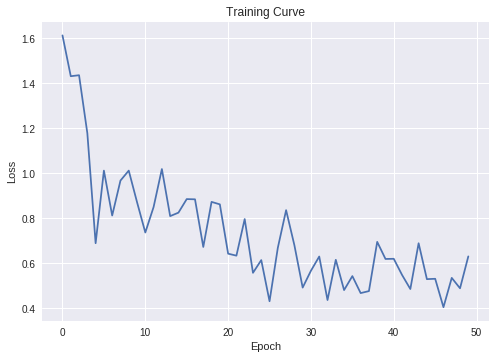

In [9]:
model = Cartmanboi(len(vocab),512,2)
train(model,num_epochs=50,batch_size=64, lr=3e-4,sq=100) 

**Evaluation Section**




In [0]:
def evaluate(model, prime_str='Kyle:', sq_length=30, predict_len=500, temperature=0.8):
    hidden = model.init_hidden(1) #create a hidden layer the size of our prime string 
    prime_input = text_to_numpy(prime_str) #convert out prime string to a np array vector 
    
    
    #create a matrix the same size as our input batches
    current_seq = np.full((1, sq_length), vocab_stoi[" "]) #create a vector to hold the predicted characters 
    
    current_seq[-1][len(current_seq)-len(prime_input)-1:] = prime_input
    predicted = prime_str #predicted holds the predicted sequence 
    current_seq = torch.from_numpy(current_seq)
    model.cuda()
    for p in range(predict_len):  #for however many characters we want to predict 
        current_seq = torch.LongTensor(current_seq).cuda() #turn our current sequence into a long tensor 
        output, hidden = model(current_seq, hidden)
#         print(hidden.shape)
#         print(current_seq.shape)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted character to string and use as next input
        predicted_char = vocab_itos[top_i] #figure out what the predicted character is
        predicted += predicted_char
        
#         print(current_seq)
        current_seq = np.roll(current_seq.cpu(), -1, 1)
#         print(current_seq)
        current_seq[-1][-1] = top_i
#         print(current_seq)

    return predicted

In [26]:
##Get the best model
net = Cartmanboi(len(vocab),128)
path = '/content/drive/My Drive/Colab Notebooks/model_c1_bs64_lr0.0003_epoch46_h512_l2_sq100'
net = torch.load(path)
print(evaluate(net.eval(),prime_str = "Kyle:",temperature=0.8))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Kyle: CHRS!  We did it! 
Cartman:	Behald, this is two for one; put your hands to win, damnit is your last walking to tell you to try. People can't believe it. 
Cartman:	You see, my frog slip is to get a hall pass goes of the tour where it isn't that cancer in my little problem. 
Zazul:	Ack, he is the Family Guy episode pulled. 
Cartman:	That's it. We're all hit his feeling angrails, the intelligent, retard alert, class.  
Cardinal Mahoney:	There goes the guy that can also care. 
Satan:	So I want the 
